Using backend: pytorch


<class 'dgl.heterograph.DGLHeteroGraph'>
45


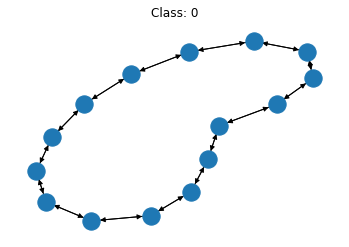

In [1]:
### Source Tutorial: https://docs.dgl.ai/en/0.4.x/tutorials/basics/4_batch.html

"""
.. currentmodule:: dgl

Graph Classification Tutorial
=============================

**Author**: `Mufei Li <https://github.com/mufeili>`_,
`Minjie Wang <https://jermainewang.github.io/>`_,
`Zheng Zhang <https://shanghai.nyu.edu/academics/faculty/directory/zheng-zhang>`_.

In this tutorial, you learn how to use DGL to batch multiple graphs of variable size and shape. The 
tutorial also demonstrates training a graph neural network for a simple graph classification task.

Graph classification is an important problem
with applications across many fields, such as bioinformatics, chemoinformatics, social
network analysis, urban computing, and cybersecurity. Applying graph neural
networks to this problem has been a popular approach recently. This can be seen in the following reserach references: 
`Ying et al., 2018 <https://arxiv.org/abs/1806.08804>`_,
`Cangea et al., 2018 <https://arxiv.org/abs/1811.01287>`_,
`Knyazev et al., 2018 <https://arxiv.org/abs/1811.09595>`_,
`Bianchi et al., 2019 <https://arxiv.org/abs/1901.01343>`_,
`Liao et al., 2019 <https://arxiv.org/abs/1901.01484>`_,
`Gao et al., 2019 <https://openreview.net/forum?id=HJePRoAct7>`_).

"""

###############################################################################
# Simple graph classification task
# --------------------------------
# In this tutorial, you learn how to perform batched graph classification
# with DGL. The example task objective is to classify eight types of topologies shown here.
#
# .. image:: https://data.dgl.ai/tutorial/batch/dataset_overview.png
#     :align: center
#
# Implement a synthetic dataset :class:`data.MiniGCDataset` in DGL. The dataset has eight 
# different types of graphs and each class has the same number of graph samples.

from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
# A dataset with 80 samples, each graph is
# of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[0]
print(type(graph))
print(graph.number_of_edges())
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()


In [2]:

###############################################################################
# Form a graph mini-batch
# -----------------------
# To train neural networks efficiently, a common practice is to batch
# multiple samples together to form a mini-batch. Batching fixed-shaped tensor
# inputs is common. For example, batching two images of size 28 x 28
# gives a tensor of shape 2 x 28 x 28. By contrast, batching graph inputs
# has two challenges:
#
# * Graphs are sparse.
# * Graphs can have various length. For example, number of nodes and edges.
#
# To address this, DGL provides a :func:`dgl.batch` API. It leverages the idea that
# a batch of graphs can be viewed as a large graph that has many disjointed 
# connected components. Below is a visualization that gives the general idea.
#
# .. image:: https://data.dgl.ai/tutorial/batch/batch.png
#     :width: 400pt
#     :align: center
#
# Define the following ``collate`` function to form a mini-batch from a given
# list of graph and label pairs.

import dgl
import torch

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    new_samples = []
    for graph, _ in samples:
        # Rather than the number of nodes, the labels changed to number of edges
        new_samples.append((graph, torch.tensor(float(graph.number_of_edges()))))
    graphs, labels = map(list, zip(*new_samples))
     
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

In [26]:
# Looking at the trainset data to see if the labels match

trainset = MiniGCDataset(320, 10, 20)
graph, label = collate(trainset)
print(trainset[250])
print(label)

(Graph(num_nodes=18, num_edges=324,
      ndata_schemes={}
      edata_schemes={}), tensor(6, dtype=torch.int32))
tensor([ 45.,  30.,  39.,  39.,  51.,  57.,  39.,  45.,  36.,  42.,  51.,  48.,
         54.,  54.,  33.,  48.,  51.,  51.,  54.,  33.,  45.,  57.,  54.,  57.,
         42.,  39.,  30.,  39.,  45.,  30.,  36.,  39.,  54.,  33.,  39.,  39.,
         39.,  51.,  30.,  33.,  55.,  55.,  28.,  40.,  49.,  37.,  34.,  49.,
         34.,  28.,  28.,  40.,  43.,  43.,  46.,  52.,  40.,  31.,  40.,  55.,
         52.,  31.,  31.,  49.,  55.,  55.,  37.,  46.,  49.,  34.,  28.,  37.,
         43.,  55.,  40.,  40.,  46.,  40.,  40.,  37.,  66.,  66.,  86.,  66.,
         61.,  81.,  71.,  71.,  46.,  51.,  71.,  91.,  61.,  46.,  71.,  46.,
         51.,  56.,  66.,  56.,  46.,  61.,  56.,  46.,  81.,  71.,  91.,  46.,
         56.,  81.,  56.,  91.,  56.,  61.,  61.,  56.,  61.,  66.,  51.,  56.,
        237.,  87., 136., 184.,  64.,  70., 202., 136., 127., 142., 142.,  64.,
      

In [4]:
###############################################################################
# Readout and classification
# --------------------------
# For this demonstration, consider initial node features to be their degrees.
# After two rounds of graph convolution, perform a graph readout by averaging
# over all node features for each graph in the batch.
#
# .. math::
#
#    h_g=\frac{1}{|\mathcal{V}|}\sum_{v\in\mathcal{V}}h_{v}
#
# In DGL, :func:`dgl.mean_nodes` handles this task for a batch of
# graphs with variable size. You then feed the graph representations into a
# classifier with one linear layer to obtain pre-softmax logits.

import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)


In [97]:

###############################################################################
# Setup and training
# ------------------
# Create a synthetic dataset of :math:`400` graphs with :math:`10` ~
# :math:`20` nodes. :math:`320` graphs constitute a training set and
# :math:`80` graphs constitute a test set.
import torch.optim as optim
from torch.utils.data import DataLoader
from dgl.nn.pytorch import GraphConv

# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)

# Create model
#modified to contain a single output
#model = Classifier(1, 256, trainset.num_classes)
#TODO: need to train hyperparameters hidden layers
model = Classifier(1, 200, 1)
loss_func = nn.MSELoss()

#modifications to migrate to regression
#loss_func = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#TODO: need to train hyperparameter learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)
model.train()

# epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
#     print(epoch_loss)
    epoch_losses.append(epoch_loss)

Epoch 0, loss 11429.8126
Epoch 1, loss 11338.0377
Epoch 2, loss 11237.3202
Epoch 3, loss 11125.3327
Epoch 4, loss 10986.6668
Epoch 5, loss 10806.7202
Epoch 6, loss 10565.5131
Epoch 7, loss 10248.1708
Epoch 8, loss 9854.3782
Epoch 9, loss 9348.3259
Epoch 10, loss 8675.0102
Epoch 11, loss 8023.8630
Epoch 12, loss 7360.8502
Epoch 13, loss 6920.3858
Epoch 14, loss 6713.7699
Epoch 15, loss 6610.3242
Epoch 16, loss 6464.8031
Epoch 17, loss 6468.2751
Epoch 18, loss 6373.9783
Epoch 19, loss 6472.2938
Epoch 20, loss 6388.7102
Epoch 21, loss 6525.5844
Epoch 22, loss 6501.7867
Epoch 23, loss 6443.6339
Epoch 24, loss 6569.3619
Epoch 25, loss 6346.0902
Epoch 26, loss 6436.9027
Epoch 27, loss 6437.2108
Epoch 28, loss 6465.2754
Epoch 29, loss 6491.2027
Epoch 30, loss 6354.9960
Epoch 31, loss 6389.2965
Epoch 32, loss 6495.3741
Epoch 33, loss 6320.0599
Epoch 34, loss 6354.1168
Epoch 35, loss 6474.7698
Epoch 36, loss 6466.4270
Epoch 37, loss 6455.1121
Epoch 38, loss 6453.9458
Epoch 39, loss 6435.9107
Ep

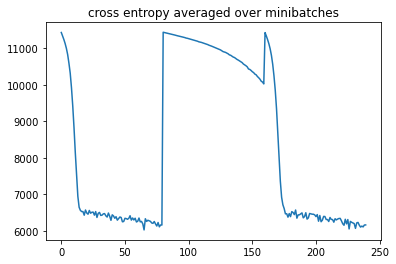

In [98]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

In [96]:

###############################################################################
# The learning curve of a run is presented below.

# plt.title('cross entropy averaged over minibatches')
# plt.plot(epoch_losses)
#plt.show()

###############################################################################
# The trained model is evaluated on the test set created. To deploy
# the tutorial, restrict the running time to get a higher
# accuracy (:math:`80` % ~ :math:`90` %) than the ones printed below.
testset = MiniGCDataset(10, 10, 11)
model.eval()

# Convert a list of tuples to two lists
new_samples = []
for graph, _ in testset:
    new_samples.append((graph, torch.tensor(float(graph.number_of_edges()))))
test_X, test_Y = map(list, zip(*new_samples))

# test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
# print(test_X)
# print(test_Y)

# probs_Y = torch.softmax(model(test_bg), 1)
probs_Y = model(test_bg)
print(probs_Y)
total_sum = 0
for i, r in enumerate(test_X):
    total_sum += probs_Y[i][0].item() - r.number_of_edges()
print("Average error: ", total_sum/len(test_Y))
# test_X, test_Y = map(list, zip(*testset))
# # print(model)
# exit()
# sampled_Y = torch.multinomial(probs_Y, 1)
# argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == probs_Y.float()).sum().item() / len(test_Y) * 100))
# print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
#     (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

tensor([[ 4.9375],
        [ 5.1904],
        [ 7.6980],
        [11.2960],
        [ 6.5044],
        [ 6.0251],
        [15.9058],
        [ 6.5044],
        [ 6.5044],
        [ 6.5044]], grad_fn=<AddmmBackward>)
-38.192945909500125
Accuracy of sampled predictions on the test set: 0.0000%
